In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [5]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [106]:
# build dataset

def build_dataset(words):
    block_size = 3 
    X, Y = [], []

    for w in words:
        context = [0] * block_size # 0 stands for . here 
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print("".join(itos[i] for i in context), "--->", itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [107]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [108]:
X.dtype, Y.dtype

(torch.int64, torch.int64)

In [109]:
import random
random.seed(42)

random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [31]:
# C = torch.randn((27, 2)) # look-up table, 27 represent 27 characters

# C[5].shape

# F.one_hot(torch.tensor(5), num_classes=27).float() @ C

# C[X].shape

# F.one_hot(X[13], num_classes=27).float() @ C

In [34]:
C = torch.randn((27, 2)) # look-up table, 27 represent 27 characters
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [32]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [37]:
# torch.cat(torch.unbind(emb, 1),1).shape

In [42]:
# a = torch.arange(18)

# a.view(2,3,3)

# a.storage()

In [46]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [47]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [48]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [52]:
counts = logits.exp()

In [53]:
prob = counts / counts.sum(1, keepdims=True)

In [54]:
prob.shape

torch.Size([32, 27])

In [59]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(21.4082)

## rewrite above

In [139]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [140]:
sum(p.nelement() for p in parameters)

11897

In [134]:
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10 ** lre

In [142]:
from tqdm import tqdm

lossi = []
stepi = []

for p in parameters:
    p.requires_grad = True

for i in tqdm(range(30000)):
    
    ix = torch.randint(0, Xtr.shape[0], (32,), generator=g)
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
    lossi.append(loss.log10().item())
    stepi.append(i)
    
print(loss.item())

100%|███████████████████████████████████| 30000/30000 [00:12<00:00, 2432.33it/s]

2.2331149578094482


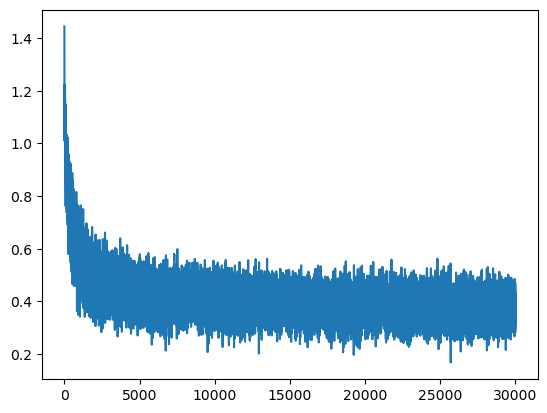

In [143]:
plt.plot(stepi, lossi)

In [145]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.3745198249816895

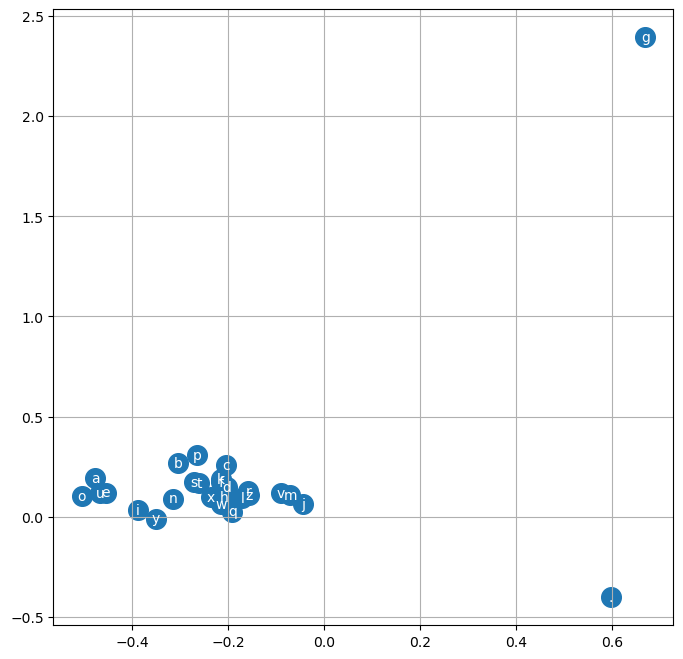

In [138]:
# visualized emb

plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [146]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[context]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break
        
    print("".join(itos[i] for i in out))

nyah.
nawiah.
jamc.
sae.
ilah.
ebmiah.
livaley.
bia.
ramilinn.
wrishiana.
je.
res.
kablisie.
gramarram.
macelinn.
zajaniah.
nan.
nin.
ane.
gevany.
